<a href="https://colab.research.google.com/github/hypro2/hands-on-LLM-from-colab/blob/main/unsloth_Llama3_1_(8B)_GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### News

**Read our [blog post](https://unsloth.ai/blog/r1-reasoning) for guidance to train reasoning model.

### 요약

- **GRPO 소개 및 개선**
  - Unsloth가 새로운 reasoning 모델 훈련 기능을 소개.
  - DeepSeek의 R1-Zero 모델이 "aha moment"을 경험하며, 인간 피드백 없이 더 많은 사고 시간을 할당.
  - 기존의 Hugging Face + FA2보다 80% 적은 VRAM을 사용하여 효율적인 GRPO 모델 훈련 가능.
  - 7GB VRAM만 있으면 Qwen2.5 모델을 사용해 reasoning 모델을 훈련할 수 있음.
  
- **GRPO 과정 및 용도**
  - GRPO를 사용해 모델이 사고 과정을 자동으로 생성하도록 훈련.
  - 1.5B 이상의 파라미터를 가진 모델에서 reasoning 기능을 생성하는 데 효과적.
  - 특정 분야(예: 법률, 의학) 맞춤형 모델을 만들 때 GRPO 사용 가능.
  - 입력과 출력 데이터만 있을 때 reasoning 과정을 자동으로 만들어주는 기능.
  
- **"Aha Moment"**
  - GRPO를 통해 모델이 초기 접근을 재평가하고 사고 시간을 확장하는 "aha moment" 경험.
  - Phi-4 모델을 사용해 100단계 훈련만으로 사고 토큰을 생성하고 올바른 답을 도출.
  
- **GRPO 작동 방식**
  - 모델은 여러 답변을 그룹화하여 정확도를 기준으로 점수화.
  - 점수 평균을 계산하고, 그에 따라 더 높은 점수를 얻는 답변을 강화.
  
- **훈련 방법 및 설치**
  - Unsloth에서 GRPO를 사용하려면 `pip install diffusers` 필수.
  - 최소 12시간 훈련이 필요하지만, 중단은 언제든 가능.
  - vLLM을 사용해 더 빠른 훈련과 추론 가능.
  
- **기타 기능 및 개선 사항**
  - Unsloth에서 Online DPO, PPO, RLOO 지원.
  - vLLM과 Unsloth 결합 시 VRAM 효율성 증가 및 더 높은 처리량 제공.
  - 훈련 손실 추적 기능이 Unsloth에 내장되어 외부 도구 불필요.

### 최종 요약
Unsloth는 GRPO를 통해 reasoning 모델 훈련을 향상시켰으며, 7GB VRAM으로도 Qwen2.5와 같은 모델에서 reasoning 능력을 훈련할 수 있게 되었다. 이 과정에서 "aha moment"을 통해 모델이 자체적으로 사고 과정을 확립하는 방식이 발견되었으며, GRPO를 통해 다양한 분야 맞춤형 모델을 구축할 수 있다. 추가적으로, Unsloth는 vLLM을 통해 VRAM 절감 및 더 높은 처리량을 제공, 여러 RL 알고리즘을 지원하며, 훈련 및 추론 속도를 개선했다.


(추가 자료 모음)

https://huggingface.co/docs/trl/main/en/grpo_trainer

https://unsloth.ai/blog/r1-reasoning

https://arxiv.org/abs/2402.03300


### Installation

In [ ]:
%%capture
# Skip restarting message in Colab
import sys; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None

!pip install unsloth vllm
!pip install --upgrade pillow
# If you are running this notebook on local, you need to install `diffusers` too
# !pip install diffusers
# Temporarily install a specific TRL nightly version
!pip install git+https://github.com/huggingface/trl.git@e95f9fb74a3c3647b86f251b7e230ec51c64b72b

### Unsloth

Use `PatchFastRL` before all functions to patch GRPO and other RL algorithms!

In [ ]:
from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

Unsloth: Patching Xformers to fix some performance issues.
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 02-10 08:00:37 __init__.py:190] Automatically detected platform cuda.


Load up `Llama 3.1 8B Instruct`, and set parameters

In [ ]:
from unsloth import is_bfloat16_supported
import torch
max_seq_length = 512 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.6, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = 3407,
)

==((====))==  Unsloth 2025.2.5: Fast Llama patching. Transformers: 4.48.2.
   \\   /|    GPU: Tesla T4. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-bnb-4bit with actual GPU utilization = 59.59%
Unsloth: Your GPU has CUDA compute capability 7.5 with VRAM = 14.74 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 512. Num Sequences = 160.
Unsloth: vLLM's KV Cache can use up to 2.61 GB. Also swap space = 2 GB.
WARNING 02-10 08:00:49 config.py:2386] Casting torch.bfloat16 to torch.float16.
INFO 02-10 08:01:17 config.py:542] This model supports multiple tasks: {'classify', 'reward', 'score', 'embed', 'generate'}. Defa

tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

INFO 02-10 08:01:24 cuda.py:179] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 02-10 08:01:24 cuda.py:227] Using XFormers backend.
INFO 02-10 08:01:26 model_runner.py:1110] Starting to load model unsloth/meta-llama-3.1-8b-instruct-bnb-4bit...
INFO 02-10 08:01:27 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 02-10 08:01:27 weight_utils.py:252] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-10 08:03:04 model_runner.py:1115] Loading model weights took 5.3541 GB
INFO 02-10 08:03:04 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-10 08:03:18 worker.py:267] Memory profiling takes 13.77 seconds
INFO 02-10 08:03:18 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.60) = 8.78GiB
INFO 02-10 08:03:18 worker.py:267] model weights take 5.35GiB; non_torch_memory takes 0.05GiB; PyTorch activation peak memory takes 0.74GiB; the rest of the memory reserved for KV Cache is 2.64GiB.
INFO 02-10 08:03:19 executor_base.py:110] # CUDA blocks: 1353, # CPU blocks: 1024
INFO 02-10 08:03:19 executor_base.py:115] Maximum concurrency for 512 tokens per request: 42.28x
INFO 02-10 08:03:21 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occ

Capturing CUDA graph shapes: 100%|██████████| 23/23 [00:39<00:00,  1.73s/it]

INFO 02-10 08:04:00 model_runner.py:1562] Graph capturing finished in 40 secs, took 0.58 GiB
INFO 02-10 08:04:00 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 56.07 seconds


tokenizer_config.json:   0%|          | 0.00/55.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

Unsloth 2025.2.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Data Prep
<a name="Data"></a>

We directly leverage [@willccbb](https://gist.github.com/willccbb/4676755236bb08cab5f4e54a0475d6fb) for data prep and all reward functions. You are free to create your own!

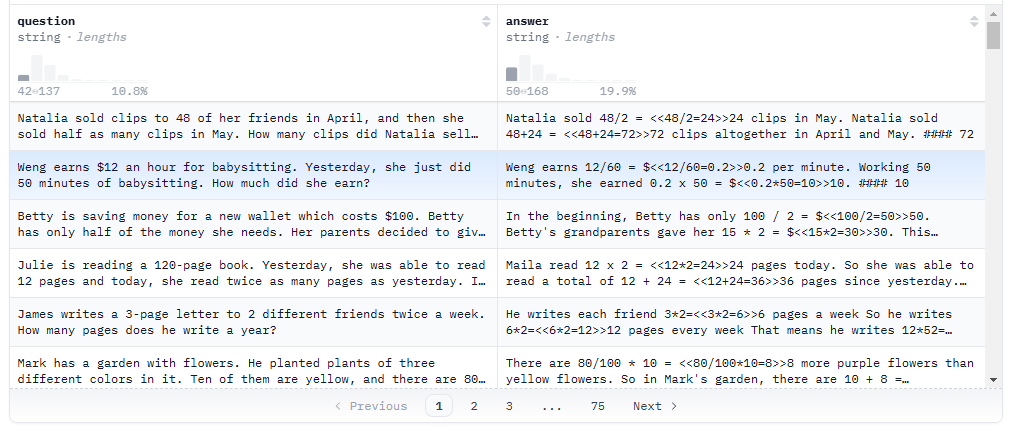

In [ ]:
import re
from datasets import load_dataset, Dataset

# 시스템 프롬프트 정의 - 응답 형식을 XML 형태로 지정
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning> ... </reasoning>
<answer> ... </answer>
"""

# XML 형식의 Chain-of-Thought (사고 과정) 포맷 정의
XML_COT_FORMAT = """\\
<reasoning> {reasoning} </reasoning>
<answer> {answer} </answer>
"""

def extract_xml_answer(text: str) -> str:
    # XML 형식에서 <answer> 태그 사이의 답변 추출
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()

def extract_hash_answer(text: str) -> str | None:
    # #### 구분자를 사용하여 답변 추출, 없으면 None 반환
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

def get_gsm8k_questions(split = "train") -> Dataset:
    # GSM8K 데이터셋 로드 및 전처리
    # 각 문제를 시스템 프롬프트와 함께 포맷팅
    data = load_dataset('openai/gsm8k', 'main')[split]
    data = data.map(lambda x: {
        'prompt': [
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': x['question']} # 훈련에서 추론+강화학습이므로 정답이 없음
        ],
        'answer': extract_hash_answer(x['answer']) # correctness_reward_func, 중간과정없이 완전 정답만 사용, 강화학습에서만 사용됨
    })
    return data


# 데이터셋 로드
dataset = get_gsm8k_questions()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [ ]:
# 보상 함수들 정의

def correctness_reward_func(prompts, completions, answer, **kwargs) -> list[float]:
    # 응답의 정확성을 평가하는 보상 함수
    # 정답과 일치하면 2.0점, 불일치하면 0.0점 부여
    responses = [completion[0]['content'] for completion in completions]
    q = prompts[0][-1]['content']
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print('-'*20, f"Question:\n{q}", f"\nAnswer:\n{answer[0]}",
          f"\nResponse:\n{responses[0]}", f"\nExtracted:\n{extracted_responses[0]}")
    return [2.0 if r == a else 0.0 for r, a in zip(extracted_responses, answer)]

def int_reward_func(completions, **kwargs) -> list[float]:
    # 응답이 정수인지 확인하는 보상 함수
    # 정수면 0.5점, 아니면 0.0점 부여
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    return [0.5 if r.isdigit() else 0.0 for r in extracted_responses]

def strict_format_reward_func(completions, **kwargs) -> list[float]:
    # 응답이 엄격한 XML 형식을 따르는지 확인하는 보상 함수
    # 형식이 정확하면 0.5점, 아니면 0.0점 부여
    pattern = r"^<reasoning>\n.*?\n</reasoning>\n<answer>\n.*?\n</answer>\n$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def soft_format_reward_func(completions, **kwargs) -> list[float]:
    # 응답이 느슨한 XML 형식을 따르는지 확인하는 보상 함수
    # 기본 태그 구조만 확인하여 0.5점 또는 0.0점 부여
    pattern = r"<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"
    responses = [completion[0]["content"] for completion in completions]
    matches = [re.match(pattern, r) for r in responses]
    return [0.5 if match else 0.0 for match in matches]

def count_xml(text) -> float:
    # XML 태그의 정확한 배치를 평가하는 점수 계산 함수
    # 각 태그의 올바른 위치와 형식에 대해 부분 점수 부여
    count = 0.0
    if text.count("<reasoning>\n") == 1:
        count += 0.125
    if text.count("\n</reasoning>\n") == 1:
        count += 0.125
    if text.count("\n<answer>\n") == 1:
        count += 0.125
        count -= len(text.split("\n</answer>\n")[-1])*0.001
    if text.count("\n</answer>") == 1:
        count += 0.125
        count -= (len(text.split("\n</answer>")[-1]) - 1)*0.001
    return count

def xmlcount_reward_func(completions, **kwargs) -> list[float]:
    # XML 태그 카운트 기반 보상 함수
    # count_xml 함수를 사용하여 각 응답의 XML 구조 점수 계산
    contents = [completion[0]["content"] for completion in completions]
    return [count_xml(c) for c in contents]

<a name="Train"></a>
### Train the model

Now set up GRPO Trainer and all configurations!

In [ ]:
from trl import GRPOConfig, GRPOTrainer
training_args = GRPOConfig(
    use_vllm = True, # use vLLM for fast inference!
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "paged_adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 1,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 6, # Decrease if out of memory
    max_prompt_length = 256,
    max_completion_length = 200,
    # num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 250,
    save_steps = 250,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

torch.distributed process group is initialized, but parallel_mode != ParallelMode.DISTRIBUTED. In order to use Torch DDP, launch your script with `python -m torch.distributed.launch


이제 트레이너를 실행해 봅시다! 위로 스크롤하면 보상 표가 표시됩니다. 목표는 '보상' 열이 증가하는 것을 보는 것입니다!

어떤 동작을 하려면 150~200걸음을 기다려야 할 수도 있습니다. 처음 100보 동안은 보상이 0이 될 수도 있습니다. 조금만 기다려주세요!

| Step | Training Loss | reward    | reward_std | completion_length | kl       |
|------|---------------|-----------|------------|-------------------|----------|
| 1    | 0.000000      | 0.125000  | 0.000000   | 200.000000        | 0.000000 |
| 2    | 0.000000      | 0.072375  | 0.248112   | 200.000000        | 0.000000 |
| 3    | 0.000000      | -0.079000 | 0.163776   | 182.500000        | 0.000005 |


In [ ]:
trainer = GRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        xmlcount_reward_func,
        soft_format_reward_func,
        strict_format_reward_func,
        int_reward_func,
        correctness_reward_func,
    ],
    args = training_args,
    train_dataset = dataset,
)
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 7,473 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 1
\        /    Total batch size = 1 | Total steps = 250
 "-____-"     Number of trainable parameters = 83,886,080


-------------------- Question:
Ahmed and Emily are having a contest to see who can get the best grade in the class. There have been 9 assignments and Ahmed has a 91 in the class. Emily has a 92. The final assignment is worth the same amount as all the other assignments. Emily got a 90 on the final assignment. What is the minimum grade Ahmed needs to get to beat Emily if all grades are whole numbers? 
Answer:
100 
Response:
To find the minimum grade Ahmed needs to beat Emily, we need to first find Emily's current total score. Since there are 9 assignments and the final assignment is worth the same as all the other assignments, we can assume each assignment is worth 10 points for simplicity. 

Emily's current total score is 9 * 92 = 828 points. With the final assignment worth 90 points, her new total score would be 828 + 90 = 918 points.

Since there are a total of 10 assignments and each is worth 10 points, the maximum possible total score is 10 * 100 = 1000 points.

Now we can find the

Step,Training Loss,reward,reward_std,completion_length,kl
1,0.000000,0.000000,0.000000,198.833344,0.000000
2,0.000000,0.000000,0.000000,176.333344,0.000000
3,0.000000,0.416667,1.020621,145.166672,0.000000
4,0.000000,0.000000,0.000000,194.833344,0.000005
5,0.000000,0.000000,0.000000,191.500000,0.000005
6,0.000000,0.000000,0.000000,131.666672,0.000007
7,0.000000,0.416667,1.020621,133.000000,0.000007
8,0.000000,0.416667,1.020621,169.666672,0.000003
9,0.000000,0.000000,0.000000,156.333344,0.000007
10,0.000000,0.020833,0.051031,111.666672,0.000008


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

According to the problem, in 'x' years, Beth's age will be twice her sister's age. 

This can be represented as: B + x = 2(S + x).

Substituting the values of B and S in this equation, we get: 
18 + x = 2(5 + x)

Simplifying the equation, we get:
18 + x = 10 + 2x

Now, we need to isolate 'x'. 

Subtract x from both sides: 
18 = 10 + x

Subtract 10 from both sides:
8 = x

Therefore, in 8 years 
Extracted:
Let B be Beth's age and S be her sister's age. 

In 'x' years, Beth's age will be B + x and her sister's age will be S + x. 

We are given that Beth is 18 and her sister is 5. 

So, B = 18 and S = 5. 

According to the problem, in 'x' years, Beth's age will be twice her sister's age. 

This can be represented as: B + x = 2(S + x).

Substituting the values of B and S in this equation, we get: 
18 + x = 2(5 + x)

Simplifying the equation, we get:
18 + x = 10 + 2x

Now, we need to isolate 'x'. 

Subtract x from both sides: 
18 = 10 + x

Subtract 10 fro

TrainOutput(global_step=250, training_loss=0.0009105843377574701, metrics={'train_runtime': 11338.9161, 'train_samples_per_second': 0.022, 'train_steps_per_second': 0.022, 'total_flos': 0.0, 'train_loss': 0.0009105843377574701})

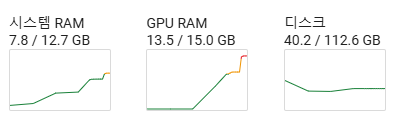

<a name="Inference"></a>
### Inference
이제 방금 훈련한 모델을 사용해 보겠습니다! 먼저 GRPO를 학습시키지 않은 모델을 사용해 보겠습니다:

In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "user", "content" : "Calculate pi."},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    [text],
    sampling_params = sampling_params,
    lora_request = None,
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:26<00:00, 26.62s/it, est. speed input: 1.47 toks/s, output: 17.81 toks/s]


'Calculating pi is a complex mathematical problem that has been studied for centuries. There are various methods to calculate pi, including:\n\n1. **Archimedes\' Method**: This ancient method involves inscribing and circumscribing polygons around a circle to estimate its circumference and area. Archimedes approximated pi as 3.1418.\n2. **Leibniz Formula**: This method uses an infinite series to calculate pi. It is based on the Gregory-Leibniz series, which states that pi/4 = 1 - 1/3 + 1/5 - 1/7 + ... .\n3. **Babylonian Method**: This method uses a recursive formula to calculate pi. It involves summing the reciprocals of the squares of the integers.\n4. **Chudnovsky Algorithm**: This is a more advanced method that uses a series of complex numbers to calculate pi.\n\nHere is a simple Python code snippet that uses the Leibniz formula to calculate pi:\n\n```python\ndef calculate_pi(n):\n    pi = 0.0\n    for i in range(n):\n        pi += ((-1) ** i) / (2 * i + 1)\n    return 4 * pi\n\n# Ca

그리고 이제 우리는 방금 GRPO로 훈련한 LoRA로 먼저 LoRA를 저장합니다!

In [ ]:
model.save_lora("grpo_saved_lora")

Now we load the LoRA and test:

In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : SYSTEM_PROMPT},
    {"role" : "user", "content" : "Calculate pi."},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output

Processed prompts: 100%|██████████| 1/1 [00:25<00:00, 25.60s/it, est. speed input: 2.38 toks/s, output: 15.98 toks/s]


"To calculate pi (π), we can use various mathematical formulas and methods. Here are a few:\n\n**Method 1: Leibniz Formula**\n\nπ = 4 * (1 - 1/3 + 1/5 - 1/7 + 1/9 - ...) (infinite series)\n\nThis method involves an infinite series that converges slowly to the value of pi.\n\n**Method 2: Madhava's Formula**\n\nπ = 3 + 4/(2*3*4) - 4/(2*3*4*5) + 4/(2*3*4*5*6) - ... (infinite series)\n\nThis method also involves an infinite series that converges slowly to the value of pi.\n\n**Method 3: Monte Carlo Method**\n\nπ = 4 * (number of points inside circle) / (total number of points)\n\nThis method involves generating random points inside and outside a circle and using the ratio of points inside the circle to estimate the value of pi.\n\n**Method 4: Bailey-Borwein-Plouffe Formula**\n\nπ = Σ (1/(16^k)) * (4/(8k+1) - 2/(8k+4) - 1/(8k+5) - 1/(8k+6)) from k=0 to infinity\n\nThis method involves an infinite series that converges relatively quickly to the value of pi.\n\n**Method 5: Digit-by-Digit Comp

추론 모델은 한 시간 정도만 훈련했기 때문에 항상 정확한 것은 아니며, 시퀀스 길이를 늘리고 더 오래 훈련하면 훨씬 더 좋아질 것입니다!

<a name="Save"></a>
### Saving to float16 for VLLM

float16`에 직접 저장하는 것도 지원합니다. float16의 경우 `merged_16bit`, int4의 경우 `merged_4bit`를 선택하세요. 또한 `lora` 어댑터를 폴백으로 사용할 수 있습니다. 푸시_투_허브_병합`을 사용해 허깅페이스 계정에 업로드하세요! 개인 토큰은 https://huggingface.co/settings/tokens 에서 확인할 수 있습니다.

In [ ]:
# # Merge to 16bit
# if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
# if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# # Merge to 4bit
# if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
# if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# # Just LoRA adapters
# if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
# if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp 변환
GGUF` / `llama.cpp`에 저장하는 것은 이제 기본적으로 지원됩니다! llama.cpp`를 복제하면 기본적으로 `q8_0`에 저장됩니다. q4_k_m`과 같은 모든 메서드를 허용합니다. 로컬 저장에는 `save_pretrained_gguf`를, HF에 업로드할 때는 `push_to_hub_gguf`를 사용합니다.

일부 지원되는 퀀트 메서드(전체 목록은 [위키 페이지](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)에 있음):
* `q8_0` - 빠른 변환. 리소스 사용량이 높지만 일반적으로 허용됩니다.
* `q4_k_m` - 권장. attention.wv 및 feed_forward.w2 텐서의 절반에는 Q6_K를 사용하고, 그 외에는 Q4_K를 사용합니다.
* `q5_k_m` - 권장. attention.wv 및 feed_forward.w2 텐서의 절반에 Q6_K를 사용하고, 그렇지 않으면 Q5_K를 사용합니다.

[**NEW**] Ollama로 미세 조정 및 자동 내보내기를 하려면 [Ollama 노트북](https://colab.research.google.com/drive/1WZDi7APtQ9VsvOrQSSC5DDtxq159j8iZ?usp=sharing)을 사용해보세요.

In [ ]:
# # Save to 8bit Q8_0
# if False: model.save_pretrained_gguf("model", tokenizer,)
# # Remember to go to https://huggingface.co/settings/tokens for a token!
# # And change hf to your username!
# if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# # Save to 16bit GGUF
# if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
# if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# # Save to q4_k_m GGUF
# if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
# if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# # Save to multiple GGUF options - much faster if you want multiple!
# if False:
#     model.push_to_hub_gguf(
#         "hf/model", # Change hf to your username!
#         tokenizer,
#         quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
#         token = "",
#     )